# QUESTION 2

Insurance.csv - Regression problem

2 a) Hadoop commands
hadoop fs -copyFromLocal /home/ashok/Download/insurance.csv

2 b) This data set allows analysis of the customer's profile. 
As it can help a factor insurance company in interacting among the various features such as age, BMI, 
smoking patterns in order to forecast insurance premiums for new customers and adjust those of existing customers. 
It can also help predict insurance premiums, preventing the insurer from underbilling a person at risk and therefore 
maximizing profits by charging them appropriately.



In [1]:
import numpy as np

from pyspark.ml.feature import StringIndexer, OneHotEncoder

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler, StandardScaler
from pyspark.ml import Pipeline

#ML Linear Regression
from pyspark.ml.regression import LinearRegression
#Ml Decision tree regressor
from pyspark.ml.regression import DecisionTreeRegressor
#ML Random Forest regressor
from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import time

In [2]:
df=spark.read.csv(path="insurance.csv", sep=",", header=True, inferSchema=True)

In [3]:
df.show(10)

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
+---+------+------+--------+------+---------+-----------+
only showing top 10 rows



# Data Exploration

In [4]:
df.columns

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [5]:
len(df.columns)

7

In [6]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [7]:
df.head(5)

[Row(age=19, sex='female', bmi=27.9, children=0, smoker='yes', region='southwest', charges=16884.924),
 Row(age=18, sex='male', bmi=33.77, children=1, smoker='no', region='southeast', charges=1725.5523),
 Row(age=28, sex='male', bmi=33.0, children=3, smoker='no', region='southeast', charges=4449.462),
 Row(age=33, sex='male', bmi=22.705, children=0, smoker='no', region='northwest', charges=21984.47061),
 Row(age=32, sex='male', bmi=28.88, children=0, smoker='no', region='northwest', charges=3866.8552)]

In [8]:
df.select("charges").show(5)

+-----------+
|    charges|
+-----------+
|  16884.924|
|  1725.5523|
|   4449.462|
|21984.47061|
|  3866.8552|
+-----------+
only showing top 5 rows



In [9]:
df.count()

1338

In [10]:
df.groupby('smoker').count().show()

+------+-----+
|smoker|count|
+------+-----+
|    no| 1064|
|   yes|  274|
+------+-----+



In [11]:
df.groupby('region').count().show()

+---------+-----+
|   region|count|
+---------+-----+
|northwest|  325|
|southeast|  364|
|northeast|  324|
|southwest|  325|
+---------+-----+



In [12]:
df.groupby('sex').count().show()

+------+-----+
|   sex|count|
+------+-----+
|female|  662|
|  male|  676|
+------+-----+



In [13]:
df.describe().show(5)

+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|summary|               age|   sex|               bmi|         children|smoker|   region|           charges|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  null|30.663396860986538|  1.0949177877429|  null|     null|13270.422265141257|
| stddev|14.049960379216147|  null| 6.098186911679012|1.205492739781914|  null|     null|12110.011236693992|
|    min|                18|female|             15.96|                0|    no|northeast|         1121.8739|
|    max|                64|  male|             53.13|                5|   yes|southwest|       63770.42801|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+



In [14]:
df.select("age").show(10)

+---+
|age|
+---+
| 19|
| 18|
| 28|
| 33|
| 32|
| 31|
| 46|
| 37|
| 37|
| 60|
+---+
only showing top 10 rows



In [15]:
df.corr('age','charges')

0.299008193330648

In [16]:
df.corr('bmi','charges')

0.19834096883362903

In [17]:
df.corr('children','charges')

0.06799822684790492

In [18]:
vec=VectorAssembler(
    inputCols=['age',"bmi",'children','charges'],
    outputCol='numeric')
data=vec.transform(df).select('numeric')

In [19]:
data.show(10)

+--------------------+
|             numeric|
+--------------------+
|[19.0,27.9,0.0,16...|
|[18.0,33.77,1.0,1...|
|[28.0,33.0,3.0,44...|
|[33.0,22.705,0.0,...|
|[32.0,28.88,0.0,3...|
|[31.0,25.74,0.0,3...|
|[46.0,33.44,1.0,8...|
|[37.0,27.74,3.0,7...|
|[37.0,29.83,2.0,6...|
|[60.0,25.84,0.0,2...|
+--------------------+
only showing top 10 rows



In [20]:
df.columns

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [21]:
ins=df.toPandas()

In [22]:
ins.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [23]:
df.select('*').where(df.charges.isNull()).count()

0

In [24]:
from pyspark.sql.functions import isnan, when, count, col
def get_null_value_count(data):
    data.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in data.columns]).show()

In [25]:
get_null_value_count(df)

+---+---+---+--------+------+------+-------+
|age|sex|bmi|children|smoker|region|charges|
+---+---+---+--------+------+------+-------+
|  0|  0|  0|       0|     0|     0|      0|
+---+---+---+--------+------+------+-------+



In [26]:
df.dtypes

[('age', 'int'),
 ('sex', 'string'),
 ('bmi', 'double'),
 ('children', 'int'),
 ('smoker', 'string'),
 ('region', 'string'),
 ('charges', 'double')]

In [27]:
 cat_cols=[c[0] for c in df.dtypes if c[1]=="string"]

In [28]:
cat_cols

['sex', 'smoker', 'region']

In [29]:
num_cols=[c[0] for c in df.dtypes if c[1]!="string"]
num_cols

['age', 'bmi', 'children', 'charges']

In [30]:
num_cols=num_cols[0:3]
num_cols

['age', 'bmi', 'children']

In [31]:
ohe_cols=[c+"_ohe" for c in cat_cols]
ohe_cols

['sex_ohe', 'smoker_ohe', 'region_ohe']

In [32]:
cat_cols_si= [c+"_index" for c in cat_cols]
print (cat_cols_si)

['sex_index', 'smoker_index', 'region_index']


In [33]:
cat_cols_ohe= [c+"_ohe" for c in cat_cols]
print (cat_cols_ohe)

['sex_ohe', 'smoker_ohe', 'region_ohe']


In [34]:
df.groupby('region').count().show()

+---------+-----+
|   region|count|
+---------+-----+
|northwest|  325|
|southeast|  364|
|northeast|  324|
|southwest|  325|
+---------+-----+



In [35]:
df.groupby('region').count().orderBy("count", ascending=False).first()[0]

'southeast'

In [36]:
[[i, df.groupby(i).count().orderBy("count", ascending=False).first()[0]] for i in df.columns]

[['age', 18],
 ['sex', 'male'],
 ['bmi', 32.3],
 ['children', 0],
 ['smoker', 'no'],
 ['region', 'southeast'],
 ['charges', 1639.5631]]

In [37]:
## Pipeline
pipe = Pipeline(
                stages=[
                    StringIndexer(
                        inputCols=cat_cols,
                        outputCols=cat_cols_si
                    ),
                    OneHotEncoder(
                        inputCols=cat_cols_si,
                        outputCols=ohe_cols
                    ),
                    VectorAssembler(
                        inputCols=cat_cols_si+num_cols,
                        outputCol="ass_features"
                    ),
                    StandardScaler(
                        inputCol="ass_features",
                        outputCol="features"
                    )
                ]
    )

In [38]:
cat_cols

['sex', 'smoker', 'region']

In [39]:
model=pipe.fit(df)

df_trans=model.transform(df)

In [40]:
print (df_trans.columns)

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'sex_index', 'smoker_index', 'region_index', 'sex_ohe', 'smoker_ohe', 'region_ohe', 'ass_features', 'features']


In [41]:
len(df.columns)

7

In [42]:
len(df_trans.columns)

15

# Train-Test Split

In [43]:
train, test=df.randomSplit([0.8,0.2], seed=12345)

In [44]:
train.count()

1094

In [45]:
test.count()

244

# Decision Tree Regressor

In [46]:
pipe2 = Pipeline(
                stages=[
                 
                    StringIndexer(
                        inputCols=cat_cols,
                        handleInvalid='keep',
                        outputCols=cat_cols_si
                    ),
                    OneHotEncoder(
                        inputCols=cat_cols_si,
                        outputCols=ohe_cols
                    ),
                    VectorAssembler(
                        inputCols=cat_cols_si+num_cols,
                        outputCol="ass_features"
                    ),
                    StandardScaler(
                        inputCol="ass_features",
                        outputCol="features"
                    ),
                    DecisionTreeRegressor(labelCol="charges", featuresCol="features")
                ]
    )

In [47]:
# Create initial Decision Tree Model
dt = DecisionTreeRegressor(labelCol="charges", featuresCol="features")

In [48]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
# Create ParamGrid for Cross Validation
dtparamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(dt.maxBins, [10, 20, 40, 80, 100])
             .build())

In [49]:
# Evaluate model
dtevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="charges", metricName="rmse")

In [50]:
# Create 5-fold CrossValidator
dtcv = CrossValidator(estimator = pipe2,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = dtevaluator,
                      numFolds = 5)

In [51]:
# Run cross validations
dtcvModel = dtcv.fit(train)
print(dtcvModel)

CrossValidatorModel_1ee7a2967de2


In [52]:
# Use test set here so we can measure the accuracy of our model on new data
dtpredictions = dtcvModel.transform(test)

# Evaluation of Decision Tree Regressor

In [53]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
rmse_dt = dtevaluator.evaluate(dtpredictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_dt)

Root Mean Squared Error (RMSE) on test data = 4849.22


# Linear Regression

In [54]:
pipe = Pipeline(
                stages=[
                 
                    StringIndexer(
                        inputCols=cat_cols,
                        handleInvalid='keep',
                        outputCols=cat_cols_si
                    ),
                    OneHotEncoder(
                        inputCols=cat_cols_si,
                        outputCols=ohe_cols
                    ),
                    VectorAssembler(
                        inputCols=cat_cols_si+num_cols,
                        outputCol="ass_features"
                    ),
                    StandardScaler(
                        inputCol="ass_features",
                        outputCol="features"
                    ),
                    LinearRegression(featuresCol= 'features', labelCol='charges')
                ]
    )

In [55]:
# Training of model
start=time.time()
lrModel=pipe.fit(train)
end=time.time()
(end-start)/60

0.06404839356740316

# Prediction of Linear Regression

In [56]:
predictions=lrModel.transform(test)

In [57]:
predictions.columns

['age',
 'sex',
 'bmi',
 'children',
 'smoker',
 'region',
 'charges',
 'sex_index',
 'smoker_index',
 'region_index',
 'sex_ohe',
 'smoker_ohe',
 'region_ohe',
 'ass_features',
 'features',
 'prediction']

In [58]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol="charges", predictionCol="prediction")

In [59]:
print('RMSE:', eval.evaluate(predictions, {eval.metricName: "rmse"}))
print('R-squared:', eval.evaluate(predictions, {eval.metricName: "r2"}))

RMSE: 6345.929492075322
R-squared: 0.7082312898173403


# Random Forest Regressor

In [60]:
pipe3 = Pipeline(
                stages=[
                 
                    StringIndexer(
                        inputCols=cat_cols,
                        handleInvalid='keep',
                        outputCols=cat_cols_si
                    ),
                    OneHotEncoder(
                        inputCols=cat_cols_si,
                        outputCols=ohe_cols
                    ),
                    VectorAssembler(
                        inputCols=cat_cols_si+num_cols,
                        outputCol="ass_features"
                    ),
                    StandardScaler(
                        inputCol="ass_features",
                        outputCol="features"
                    ),
                    RandomForestRegressor( labelCol="charges", featuresCol="features")
                ]
    )

In [61]:
rf = RandomForestRegressor(labelCol="charges", featuresCol="features")

In [62]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [63]:
# Evaluate model
rfevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="charges", metricName="rmse")

In [64]:
cross = CrossValidator(estimator=pipe3,
                          estimatorParamMaps=paramGrid,
                          evaluator=rfevaluator,
                          numFolds=3)

In [65]:
cvModel = cross.fit(train)

In [66]:
predictions = cvModel.transform(test)

# Evaluation of Random Forest Regressor

In [67]:
import matplotlib.pyplot as plt
evaluator = RegressionEvaluator(labelCol="charges", predictionCol="prediction", metricName="rmse")
rmse_rf = evaluator.evaluate(predictions)
rfPred = cvModel.transform(df)
rfResult = rfPred.toPandas()

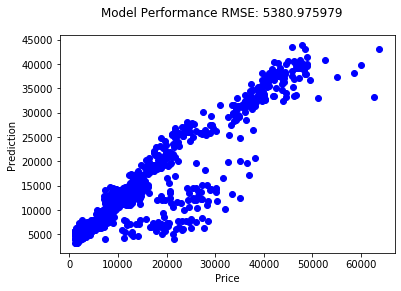

In [68]:
plt.plot(rfResult.charges, rfResult.prediction, 'bo')
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse_rf)
plt.show()

# THE VALUE OF DECISION TREE RMSE IS THE LOWEST HENCE WE ARE SELECTING THIS MODEL